# ASTR 496: Foundations of Data Science in Astronomy
# Fitting a Stellar Binary Orbit with MCMC using `emcee`
### Gautham Narayan

## Introduction

You are going to use Markov Chain Monte Carlo (MCMC) to fit the radial velocity curve of a binary star system. This is a fairly common problem in astrophysics where we observe the Doppler shift of spectral lines as stars orbit their common center of mass. You've already modeled a transit for an exoplanet light curve, so might as well model the other common method to find them.


I'll give you the physical setup - 

A binary star system with one visible component shows periodic radial velocity variations:

$$v_r(t) = K \sin\left(\frac{2\pi(t - t_0)}{P}\right) + v_0$$

where:
- $K$ = velocity semi-amplitude (km/s)
- $P$ = orbital period (days)
- $t_0$ = time of periastron passage (days)
- $v_0$ = systemic velocity (km/s)

In [22]:
# Import required packages
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from scipy import stats
# import whatever else you want here

# Set random seed for reproducibility
np.random.seed(42) # the answer to Life, the Universe, Everything



### Next, I'll create synthetic observations of a binary star system with known parameters, then add observational noise.

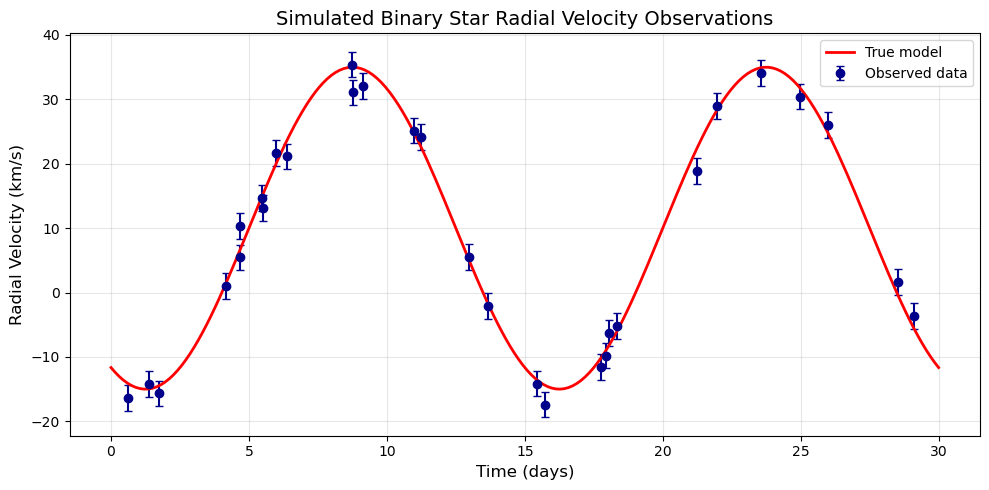

True parameters:
  K  = 25.0 km/s
  P  = 15.0 days
  t0 = 5.0 days
  v0 = 10.0 km/s


In [23]:
# True parameters (these are what we'll try to recover)
K_true = 25.0      # km/s
P_true = 15.0      # days
t0_true = 5.0      # days
v0_true = 10.0    # km/s

# Observation setup
n_obs = 30
t_obs = np.sort(np.random.uniform(0, 30, n_obs))  # Random times over 30 days
v_err = 2.0  # Measurement uncertainty (km/s)

# Model function
def radial_velocity_model(t, K, P, t0, v0):
    """Calculate radial velocity at time t for circular orbit"""
    phase = 2 * np.pi * (t - t0) / P
    return K * np.sin(phase) + v0

# Generate true signal
v_true = radial_velocity_model(t_obs, K_true, P_true, t0_true, v0_true)

# Add Gaussian noise
v_obs = v_true + np.random.normal(0, v_err, n_obs)

# Plot the data
plt.figure(figsize=(10, 5))
plt.errorbar(t_obs, v_obs, yerr=v_err, fmt='o', label='Observed data', 
             color='darkblue', markersize=6, capsize=3)
t_model = np.linspace(0, 30, 200)
v_model = radial_velocity_model(t_model, K_true, P_true, t0_true, v0_true)
plt.plot(t_model, v_model, 'r-', label='True model', linewidth=2)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Radial Velocity (km/s)', fontsize=12)
plt.title('Simulated Binary Star Radial Velocity Observations', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"True parameters:")
print(f"  K  = {K_true:.1f} km/s")
print(f"  P  = {P_true:.1f} days")
print(f"  t0 = {t0_true:.1f} days")
print(f"  v0 = {v0_true:.1f} km/s")

### OK now for the homework:

For MCMC, we need to define:
1. **Log-likelihood**: How well does a model fit the data?
2. **Log-prior**: What do we know before seeing the data?
3. **Log-posterior**: Combination of likelihood and prior (what we sample)

In [24]:
def log_likelihood(theta, t, v, v_err):
    """
    Calculate the log-likelihood of the model given the data.
    Remember
    theta : array
        Model parameters [K, P, t0, v0]
    t : array
        Observation times
    v : array
        Observed velocities
    v_err : float
        Measurement uncertainty
    """
    # you're doing this
    K, p, t0, v0 = theta

    if p<=0 or K<=0:
        return -np.inf
    
    model_radial_velocity = radial_velocity_model(t, K, p, t0, v0)

    chi2 = np.sum((v-model_radial_velocity)**2 / v_err**2)
    log_like = -0.5 * chi2

    return log_like

def log_prior(theta):
    """
    Returns -inf if parameters are outside allowed ranges.
    """
    # you're doing this

    K, P, t0, v0 = theta

    if (0 < K < 100 and
        1 < P < 100 and
        -50 < t0 < 50 and
        -50 < v0 < 50):
        return 0.0
    return -np.inf

def log_probability(theta, t, v, v_err):
    """
    Calculate the log-posterior probability.

    """
    # you're doing this

    logpost = log_prior(theta)
    if not np.isfinite(logpost):
        return -np.inf
    
    return logpost + log_likelihood(theta, t, v, v_err)

#### Justify the choice of prior in a few sentences

The prior that we use is bounded and hence will include values that are physically impossible. It allows only reasonable ranges. 

#### Describe how you treated the uncertainties in a few sentences

We treated the uncertainties by using the log likelihood function. 


#### Next setup the MCMC. 

Use the affine-invariant ensemble sampler from `emcee`. This requires:
- Initial positions for multiple "walkers" (independent MCMC chains)
- Number of steps to run

**Rule of thumb**: Use at least 2×(number of parameters) walkers.

In [25]:
# MCMC setup
ndim = 4
nwalkers = 4
nsteps = 2000
nburnin = 500
# Set some initial positions for the walkers - I'd suggest adding small random scatter around a guess
# you can get your guess from scipy.optimize or just making something up.

initial_guess = np.array([25.0,15.0,5.0,-10.0])

initial_position = initial_guess + 0.1 * np.random.randn(nwalkers, ndim)

#### Run the MCMC Sampler
This may take a minute or two.

In [26]:
# Initialize the sampler

# Run MCMC

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability,
    args=(t_obs,v_true,v_err)
)

state = sampler.run_mcmc(initial_position, nburnin, progress=True)
sampler.reset()

print(sampler.run_mcmc(state, nsteps, progress=True))
# Print the acceptance fraction from the sampler
acc_fraction = sampler.acceptance_fraction
acc_fraction

ValueError: Initial state has a large condition number. Make sure that your walkers are linearly independent for the best performance

#### Analyze the Chains

i.e. heck if the chains have "converged" (reached the posterior distribution).
Do this by plotting the `nsteps` samples from all `nwalkers` chains 

**Key concepts:**

- **Autocorrelation time**: How many steps until samples are independent
- **Burn-in**: Initial steps where walkers move from initial positions to the posterior
- **Thinning**: take every n'th sample from the chains to reduce the autocorrelation


You can look at the slides for notes on this. Make some reasonable choices! Or if you don't have a good sense, you can use a burn-in that is twice the maximum autocorrelation time, and thinning of 1/2 the minimum autocorrelation time. This implies that there are multiple autocorrelation times, and you have to figure out how. 

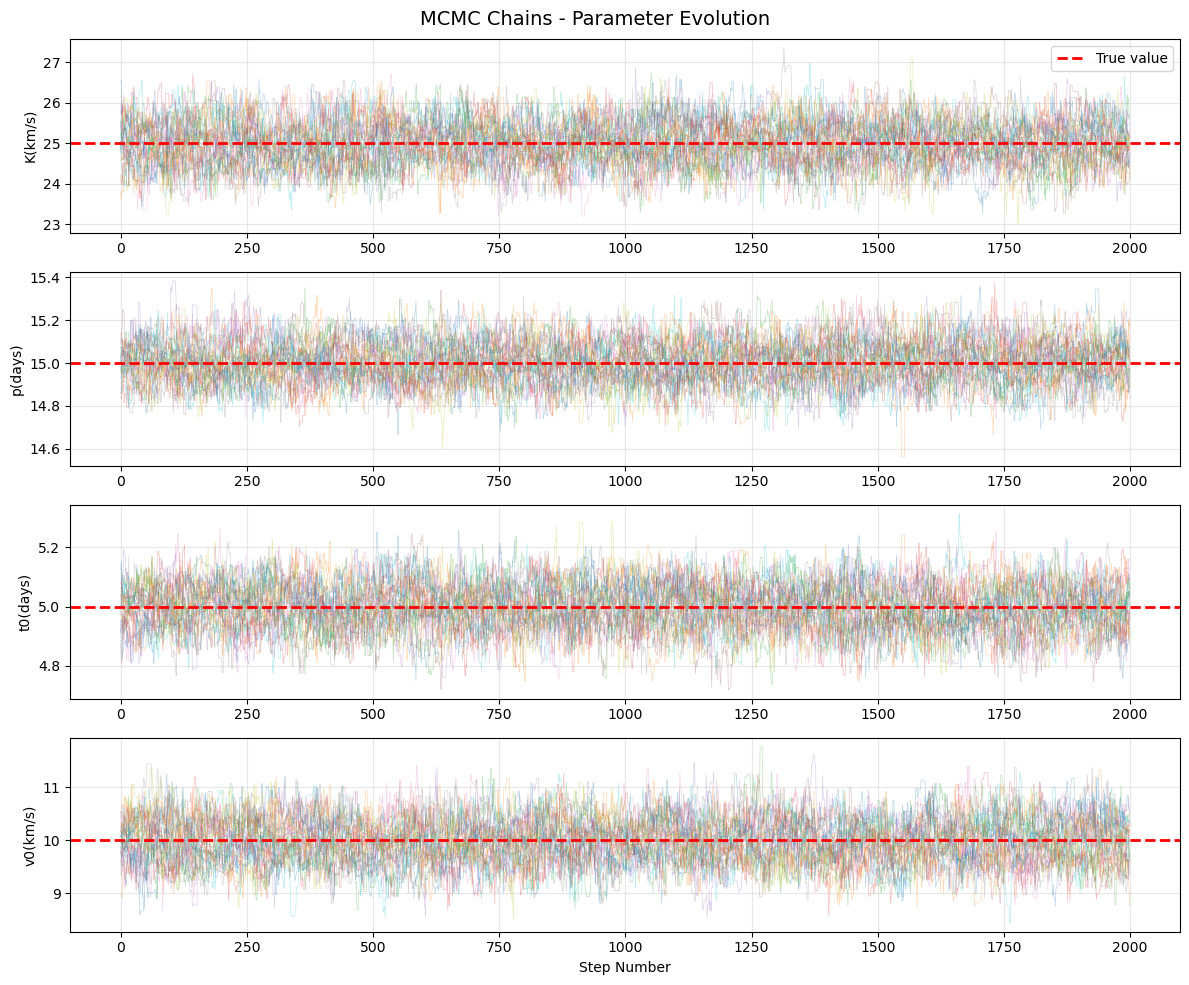

In [ ]:
# Plot the chains - and remember to label your plots - you aren't silly first-years
chain = sampler.get_chain()
fig, axes = plt.subplots(4,1, figsize=(12,10))
parameter_values = ['K(km/s)', 'p(days)','t0(days)','v0(km/s)']
true_vals = [K_true,P_true,t0_true,v0_true]
for i in range(4):
    ax = axes[i]
    for walker in range(nwalkers):
        ax.plot(chain[:, walker, i], alpha=0.3, linewidth=0.5)
    ax.axhline(y=true_vals[i], color='red', linestyle='--', linewidth=2, label='True value')
    ax.set_ylabel(parameter_values[i])
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend()

axes[3].set_xlabel('Step Number')
plt.suptitle('MCMC Chains - Parameter Evolution', fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
try:
    tau = sampler.get_autocorr_time(discard=100, quiet=True)
except:
    tau = np.array([50, 50, 50, 50])

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 38;
tau: [40.33649303 38.17709026 36.85268385 40.55040223]


#### Extract and Analyze Results

After discarding burn-in, you'll extract the posterior samples and calculate parameter estimates.

In [ ]:
# Get flattened samples (discard burn-in and thin)
max_tau = np.max(tau)
min_tau = np.min(tau)
burnin = int(2 * max_tau)
thinning = max(1, int(0.5 * min_tau))
flat_samples = sampler.get_chain(discard=burnin, thin=thinning, flat=True)
# Calculate parameter estimates
best_K, best_p, best_t0, best_v0 = np.median(flat_samples, axis=0)
unc_K = np.percentile(flat_samples[:, 0], [16, 84])
unc_p = np.percentile(flat_samples[:, 1], [16, 84])
unc_t0 = np.percentile(flat_samples[:, 2], [16, 84])
unc_v0 = np.percentile(flat_samples[:, 3], [16, 84])
print(best_K)
print(best_v0)
print(best_p)
print(best_t0)

print(unc_K)
print(unc_p)
print(unc_t0)
print(unc_v0)


24.990617231089033
9.988836874305006
15.00079357594792
4.99869840153582
[24.48670013 25.52060708]
[14.91382721 15.09622369]
[4.92483285 5.07242804]
[ 9.59843748 10.38722458]


#### Create a Corner Plot

A corner plot shows all 1D and 2D marginalized distributions, revealing parameter correlations.

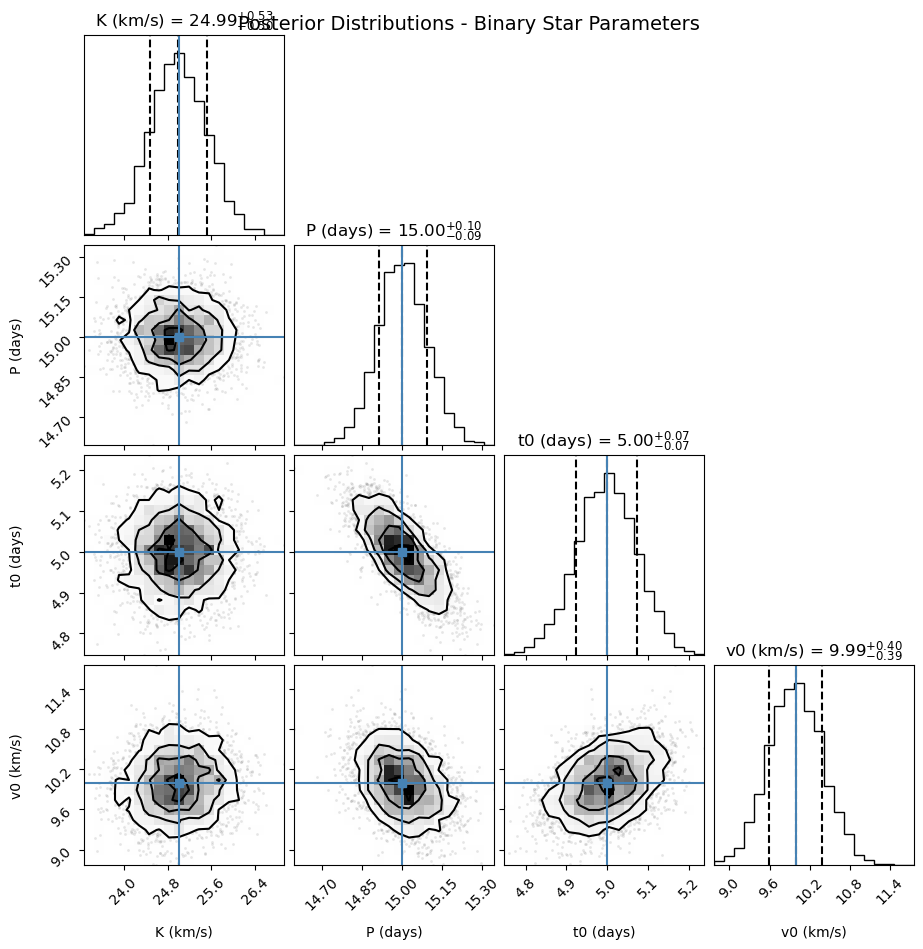

In [ ]:
# you can use the corner package 
labels = ['K (km/s)', 'P (days)', 't0 (days)', 'v0 (km/s)']
truths = [K_true, P_true, t0_true, v0_true]

fig = corner.corner(
    flat_samples, 
    labels=labels,
    truths=truths,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True
)
plt.suptitle("Posterior Distributions - Binary Star Parameters", fontsize=14)
plt.show()

#### Plot the Best-Fit Model
LOOK AT YOUR DATA. Take the median estimate to be the "best-fit"
Plot some confidence interval

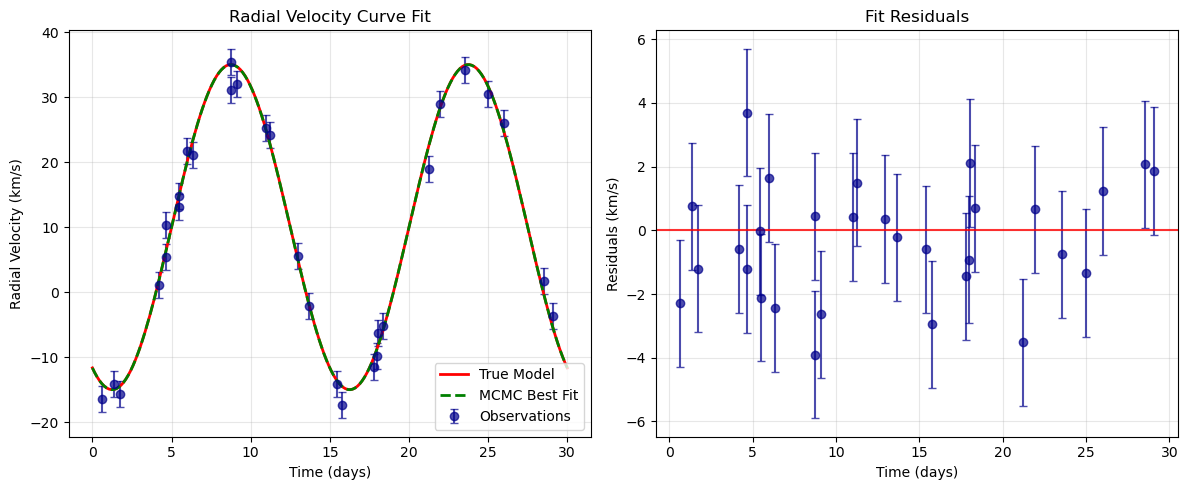

In [ ]:
# also plot the true model - you can look at the simulation code
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
t_fine = np.linspace(0, 30, 200)
best_fit = radial_velocity_model(t_fine, best_K, best_p, best_t0, best_v0)
true_curve = radial_velocity_model(t_fine, K_true, P_true, t0_true, v0_true)

plt.errorbar(t_obs, v_obs, yerr=v_err, fmt='o', label='Observations', 
             color='darkblue', markersize=6, capsize=3, alpha=0.7)
plt.plot(t_fine, true_curve, 'r-', label='True Model', linewidth=2)
plt.plot(t_fine, best_fit, 'g--', label='MCMC Best Fit', linewidth=2)
plt.xlabel('Time (days)')
plt.ylabel('Radial Velocity (km/s)')
plt.title('Radial Velocity Curve Fit')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
model_at_obs = radial_velocity_model(t_obs, best_K, best_p, best_t0, best_v0)
residuals = v_obs - model_at_obs

plt.errorbar(t_obs, residuals, yerr=v_err, fmt='o', 
             color='darkblue', markersize=6, capsize=3, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.8)
plt.xlabel('Time (days)')
plt.ylabel('Residuals (km/s)')
plt.title('Fit Residuals')
plt.grid(True, alpha=0.3)
plt.savefig('hw2-copyplot')
plt.tight_layout()
plt.show()

Finally, again a few sentences here:

**Correlations**: Examine the corner plot. Are any parameters correlated? Why might K and v₀ show correlation?

- Yes there are parameters that are correlated. K and v_0 are correlated and K and P are correlated.

**Uncertainty**: Compare the posterior uncertainties to the true values. Did our MCMC analysis recover the true parameters within the error bars?

Yes the MCMC analysis recovered the true parameters within the error bars.

**Sensitivity**: What happens if you increase the measurement uncertainty (`v_err`)? Try changing it to 10.0 km/s and rerun.

ANSWER GOES HERE - make a copy of the notebook if you need to, but just save the final plot you create above and discuss here

**Sampling**: What would happen if you used too few walkers (e.g., nwalkers=4)? Too few steps?


ANSWER GOES HERE - make a copy of the notebook if you need to, but just save the final plot you create above and discuss here
